# Analyzing Cisplatin-Binding Transcripts via GLM-SAE Knowledge Graphs

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from networkx.readwrite import json_graph

import os, json

with open("data/cisplatin_pos_kg.json") as f:
    data = json.load(f)

G: nx.MultiDiGraph = json_graph.node_link_graph(data, edges="edges")
print(G)

MultiDiGraph with 6172 nodes and 848782 edges


In [2]:
# graph is large, so lets trim down a version we can visualize
OG = G.copy()

# filter features that only respond to one token
to_remove = [n for n in G.nodes if G.in_degree(n) == 1]
G.remove_nodes_from(to_remove)
print(G)

# the '<cls>' token is the 'start' token and does not encode genetic info
if G.has_node('<cls>'):
    G.remove_node('<cls>')
    print(G)

# find average edge bundle size
edge_sizes = {(u,v): len(G.get_edge_data(u, v)) for u, v, k in G.edges}
avg_edge_size = sum(edge_sizes.values()) / len(edge_sizes)
print(f"Average edge bundle size: {avg_edge_size}")
print(f"Median edge bundle size: {np.median(list(edge_sizes.values()))}")
print(f"Number of edge bundles: {len(edge_sizes)}")
print(f"Max edge bundle size: {max(edge_sizes.values())}")
print(f"Min edge bundle size: {min(edge_sizes.values())}")
print(f"Standard deviation of edge bundle sizes: {pd.Series(edge_sizes.values()).std()}")

# filter edges that have less than 5 samples in their bundle, then show new descriptive stats
print("---------- Filtering edges with less than 5 samples in their bundle ----------")
to_remove = [key for key, size in edge_sizes.items() if size < 5]
for ebundle in to_remove:
    u, v = ebundle
    keys = list(G.get_edge_data(u, v).keys())
    for k in keys:
        G.remove_edge(u, v, k)
# G.remove_edges_from(to_remove)
print(G)

edge_sizes = {(u,v): len(G.get_edge_data(u, v)) for u, v, k in G.edges}
avg_edge_size = sum(edge_sizes.values()) / len(edge_sizes)
print(f"Average edge bundle size: {avg_edge_size}")
print(f"Median edge bundle size: {np.median(list(edge_sizes.values()))}")
print(f"Number of edge bundles: {len(edge_sizes)}")
print(f"Max edge bundle size: {max(edge_sizes.values())}")
print(f"Min edge bundle size: {min(edge_sizes.values())}")
print(f"Standard deviation of edge bundle sizes: {pd.Series(edge_sizes.values()).std()}")

# re-filter features that only respond to one token or are disconnected from the graph
to_remove = [n for n in G.nodes if G.in_degree(n) <= 1 and type(n) == int]
G.remove_nodes_from(to_remove)
print(G)

MultiDiGraph with 5879 nodes and 848489 edges
MultiDiGraph with 5878 nodes and 804654 edges
Average edge bundle size: 5.4587231271242205
Median edge bundle size: 1.0
Number of edge bundles: 147407
Max edge bundle size: 8785
Min edge bundle size: 1
Standard deviation of edge bundle sizes: 51.929513896535106
---------- Filtering edges with less than 5 samples in their bundle ----------
MultiDiGraph with 5878 nodes and 628643 edges
Average edge bundle size: 23.83480568720379
Median edge bundle size: 10.0
Number of edge bundles: 26375
Max edge bundle size: 8785
Min edge bundle size: 5
Standard deviation of edge bundle sizes: 121.06815764725847
MultiDiGraph with 4847 nodes and 628643 edges


In [3]:
# use annotations to create two graphs of coding and non-coding genomic regions
coding_regions = [e for e in G.edges(data=True, keys=True) if len(e[3]["annotations"]) != 0]
non_coding_regions = [e for e in G.edges(data=True, keys=True) if len(e[3]["annotations"]) == 0]

G_coding = nx.MultiDiGraph()
for edge in coding_regions:
    G_coding.add_edge(edge[0], edge[1], edge[2], **edge[3])
G_non_coding = nx.MultiDiGraph()
for edge in non_coding_regions:
    G_non_coding.add_edge(edge[0], edge[1], edge[2], **edge[3])

print(f"Coding graph: {G_coding}")
print(f"Non-coding graph: {G_non_coding}")

Coding graph: MultiDiGraph with 4259 nodes and 57857 edges
Non-coding graph: MultiDiGraph with 4819 nodes and 570786 edges


In [4]:
def node_color(x):
    return "lightblue" if type(x) == str else "red"

In [5]:
print("--- CODING SEQUENCES ---")

pagerank = nx.pagerank(G_coding)
sorted_pr = sorted(pagerank.items(), key=lambda item: item[1], reverse=True)
print("Top 10 nodes by PageRank:")
for node, pr in sorted_pr[:10]:
    print(f"Node: {node}, PageRank: {pr}")

degree_centrality = nx.out_degree_centrality(G_coding)
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print("Top 10 nodes by Out-Degree Centrality:")
for node, dc in sorted_degree[:10]:
    print(f"Node: {node}, Out-Degree Centrality: {dc}")

#nx.draw(G_coding, pos=nx.forceatlas2_layout(G_coding), with_labels=False, node_size=10, font_size=4, node_color=[node_color(n) for n in G_coding.nodes()])

--- CODING SEQUENCES ---
Top 10 nodes by PageRank:
Node: 3378, PageRank: 0.0954266669857938
Node: 4793, PageRank: 0.08614907113905293
Node: 407, PageRank: 0.061096425645242314
Node: 2558, PageRank: 0.03625600953741979
Node: 1545, PageRank: 0.023343081013678275
Node: 7612, PageRank: 0.012794219706204188
Node: 4014, PageRank: 0.012123968309706341
Node: 6445, PageRank: 0.011541107115998062
Node: 8707, PageRank: 0.009984743551191775
Node: 5234, PageRank: 0.006128120327257333
Top 10 nodes by Out-Degree Centrality:
Node: G, Out-Degree Centrality: 0.678252700798497
Node: C, Out-Degree Centrality: 0.646782527007985
Node: A, Out-Degree Centrality: 0.5441521841240019
Node: T, Out-Degree Centrality: 0.5345232503522781
Node: GCCGCC, Out-Degree Centrality: 0.02912165335838422
Node: CCGCCG, Out-Degree Centrality: 0.02747768905589479
Node: CGCCGC, Out-Degree Centrality: 0.025129168623767028
Node: GAGGAG, Out-Degree Centrality: 0.022545796148426493
Node: GGCGGC, Out-Degree Centrality: 0.02160638797557

In [6]:
print("--- NON-CODING SEQUENCES ---")

pagerank = nx.pagerank(G_non_coding)
sorted_pr = sorted(pagerank.items(), key=lambda item: item[1], reverse=True)
print("Top 10 nodes by PageRank:")
for node, pr in sorted_pr[:10]:
    print(f"Node: {node}, PageRank: {pr}")

degree_centrality = nx.out_degree_centrality(G_non_coding)
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print("Top 10 nodes by Out-Degree Centrality:")
for node, dc in sorted_degree[:10]:
    print(f"Node: {node}, Out-Degree Centrality: {dc}")


#nx.draw(G_non_coding, pos=nx.forceatlas2_layout(G_non_coding), with_labels=False, node_size=10, font_size=4, node_color=[node_color(n) for n in G_non_coding.nodes()])

--- NON-CODING SEQUENCES ---
Top 10 nodes by PageRank:
Node: 4793, PageRank: 0.08619088307944313
Node: 3378, PageRank: 0.08197376340176783
Node: 407, PageRank: 0.06606307825285299
Node: 2558, PageRank: 0.03135147332159834
Node: 1545, PageRank: 0.02090430544453861
Node: 6445, PageRank: 0.011221303671365012
Node: 4014, PageRank: 0.010348503106505865
Node: 7612, PageRank: 0.010329536147393735
Node: 8707, PageRank: 0.009763513600654507
Node: 5234, PageRank: 0.0055785592500795
Top 10 nodes by Out-Degree Centrality:
Node: C, Out-Degree Centrality: 5.712121212121212
Node: G, Out-Degree Centrality: 5.5226234952262345
Node: T, Out-Degree Centrality: 4.909713574097136
Node: A, Out-Degree Centrality: 4.7339144873391446
Node: CCTCCC, Out-Degree Centrality: 0.2254047322540473
Node: TTTTTT, Out-Degree Centrality: 0.17393109173931093
Node: GCCTCC, Out-Degree Centrality: 0.1631382316313823
Node: CCCAGC, Out-Degree Centrality: 0.15960979659609797
Node: CTCCTG, Out-Degree Centrality: 0.1552511415525114


In [7]:
# COMPARE TO ORIGINAL GRAPH
# use page rank to measure centrality
pagerank = nx.pagerank(OG)
sorted_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)

print("Nodes ranked by PageRank:")
for node, score in sorted_pagerank[:10]:  # top 10 nodes
    print(f"{node}: {score}")

Nodes ranked by PageRank:
3378: 0.05591438534474252
4793: 0.04776315882634009
407: 0.04058334611930585
2558: 0.02174499892379862
1545: 0.014473227554864115
7612: 0.009225784115039545
6445: 0.00832866187503917
8707: 0.008153740563806095
4014: 0.00770609877987153
9685: 0.005610925728333565


In [8]:
# COMPARE TO ORIGINAL GRAPH
# compare with degree centrality for important tokens
degree_centrality = nx.out_degree_centrality(OG)
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

print("Nodes ranked by Degree Centrality:")
for node, score in sorted_degree[:10]:  # top 10 nodes
    print(f"{node}: {score}")

Nodes ranked by Degree Centrality:
<cls>: 7.103386809269162
C: 5.001782531194296
G: 4.875384864689678
T: 4.280343542375628
A: 4.147139847674607
CCTCCC: 0.19850915572840708
TTTTTT: 0.1523253929671042
GCCTCC: 0.15119105493437043
CCCAGC: 0.14584346135148274
GCCGCC: 0.14195430238210988


In [9]:
# export to cytoscape for visualization
# Didn't work for the large graph, so just keeping for documentation
for node in OG.nodes():
    OG.nodes[node]['id'] = node

cyto_data = nx.readwrite.json_graph.cytoscape_data(OG)
with open("data/cisplatin_pos_kg_cyto.json", "w") as f:
    json.dump(cyto_data, f)

# Using Knowledge Graph Patterns to Create Gene Sets

Note the strong centrality in multiple segments of the graph for features 3378, 407, and 4793, as well as typical base pairing hairpin motifs with high GC content in the outbound central nodes. 

By gathering data from the edges associated with each major feature, we can create gene sets based on GLM feature output. 

In [10]:
# Note that our non-coding graph lacks annotations by definition, so we will only create gene sets for coding regions
# 3378
edges = G_coding.in_edges(3378, data="annotations")

genes = []
motifs = []
for u, v, annotations in edges:
    for key, val in annotations.items():
        genes.append(val["gene_id"])
        motifs.append(u)

os.makedirs("data/gene_sets", exist_ok=True)

with open("data/gene_sets/feature_3378_genes.txt", "w") as f:
    f.write("\n".join(set(genes)))

with open("data/gene_sets/feature_3378_motifs.txt", "w") as f:
    f.write("\n".join(set(motifs)))

# 407
edges = G_coding.in_edges(407, data="annotations")

genes = []
motifs = []
for u, v, annotations in edges:
    for key, val in annotations.items():
        genes.append(val["gene_id"])
        motifs.append(u)

with open("data/gene_sets/feature_407_genes.txt", "w") as f:
    f.write("\n".join(set(genes)))

with open("data/gene_sets/feature_407_motifs.txt", "w") as f:
    f.write("\n".join(set(motifs)))


# 4793
edges = G_coding.in_edges(4793, data="annotations")

genes = []
motifs = []
for u, v, annotations in edges:
    for key, val in annotations.items():
        genes.append(val["gene_id"])
        motifs.append(u)

with open("data/gene_sets/feature_4793_genes.txt", "w") as f:
    f.write("\n".join(set(genes)))

with open("data/gene_sets/feature_4793_motifs.txt", "w") as f:
    f.write("\n".join(set(motifs)))


# Community Detection

In [11]:
# Louvain
communities = nx.community.louvain_communities(OG.to_undirected(), resolution=1.5)
print(f"Found {len(communities)} communities")

Found 18 communities


Community 0:
 Central Features (In-Degree Centrality):
  Node: 5746, In-Degree Centrality: 43835.0
  Node: <cls>, In-Degree Centrality: 0.0
 Central Motifs (Out-Degree Centrality):
  Node: <cls>, Out-Degree Centrality: 43835.0
  Node: 5746, Out-Degree Centrality: 0.0


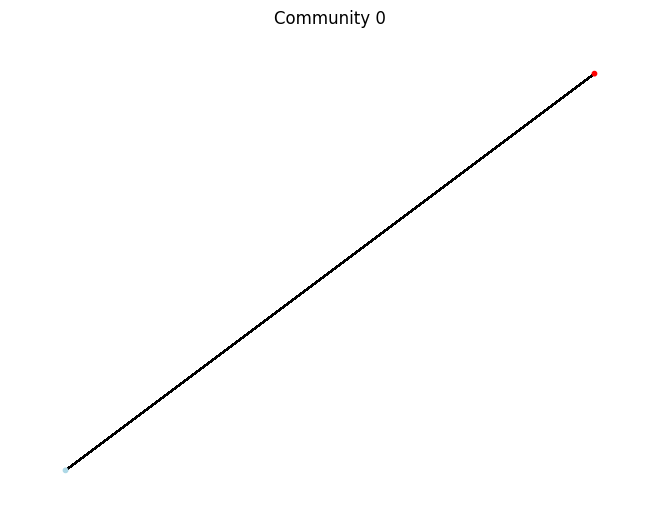

Community 1:
 Central Features (In-Degree Centrality):
  Node: 3378, In-Degree Centrality: 110.05350318471336
  Node: 6940, In-Degree Centrality: 0.5146496815286624
  Node: 7779, In-Degree Centrality: 0.4815286624203821
  Node: 1445, In-Degree Centrality: 0.33885350318471336
  Node: 4692, In-Degree Centrality: 0.16050955414012738
 Central Motifs (Out-Degree Centrality):
  Node: CCTCCC, Out-Degree Centrality: 1.2700636942675159
  Node: CTCCTG, Out-Degree Centrality: 0.9541401273885349
  Node: CCTCCT, Out-Degree Centrality: 0.8942675159235668
  Node: CTCCTC, Out-Degree Centrality: 0.7910828025477706
  Node: CCTGCC, Out-Degree Centrality: 0.7566878980891719


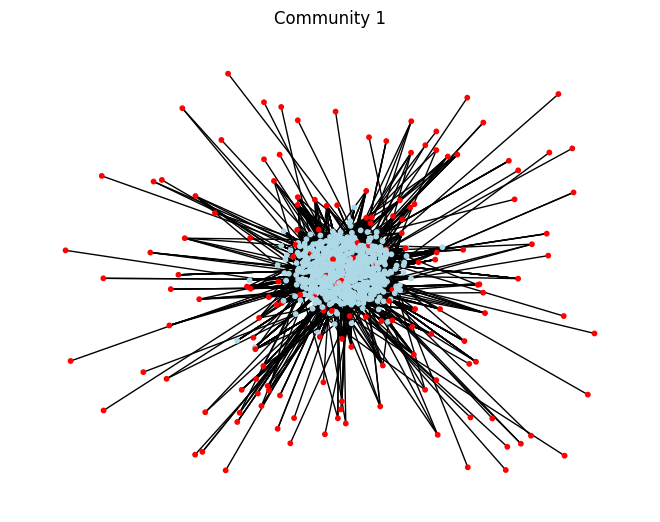

Community 2:
 Central Features (In-Degree Centrality):
  Node: 7612, In-Degree Centrality: 15.324200913242008
  Node: 1299, In-Degree Centrality: 4.440639269406392
  Node: 6371, In-Degree Centrality: 2.2511415525114153
  Node: 6110, In-Degree Centrality: 2.1095890410958904
  Node: 9341, In-Degree Centrality: 1.226027397260274
 Central Motifs (Out-Degree Centrality):
  Node: CAGCAG, Out-Degree Centrality: 0.7054794520547945
  Node: CAGCTC, Out-Degree Centrality: 0.6986301369863013
  Node: CACCTC, Out-Degree Centrality: 0.6552511415525114
  Node: CAGCAC, Out-Degree Centrality: 0.6210045662100456
  Node: AGCCTC, Out-Degree Centrality: 0.4794520547945205


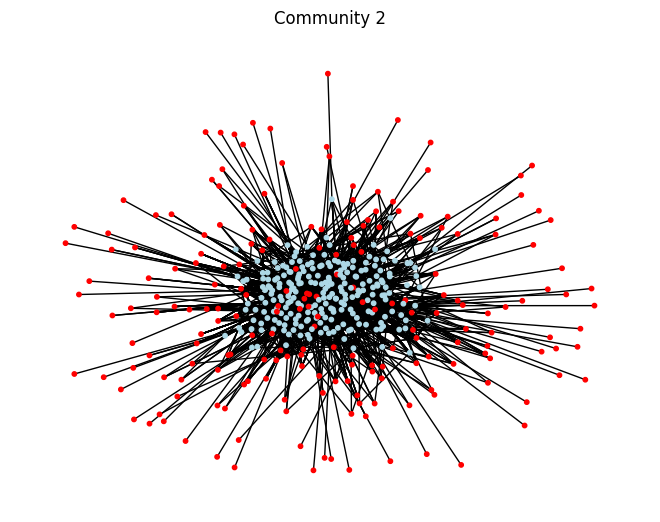

Community 3:
 Central Features (In-Degree Centrality):
  Node: 1545, In-Degree Centrality: 12.038067349926793
  Node: 10234, In-Degree Centrality: 5.238653001464129
  Node: 5503, In-Degree Centrality: 1.945827232796486
  Node: 1160, In-Degree Centrality: 1.1742313323572475
  Node: 1321, In-Degree Centrality: 1.150805270863836
 Central Motifs (Out-Degree Centrality):
  Node: GGCCTC, Out-Degree Centrality: 0.2547584187408492
  Node: GGCTGC, Out-Degree Centrality: 0.2445095168374817
  Node: GACCTC, Out-Degree Centrality: 0.23133235724743778
  Node: TGACCT, Out-Degree Centrality: 0.19326500732064422
  Node: GGACCC, Out-Degree Centrality: 0.1800878477306003


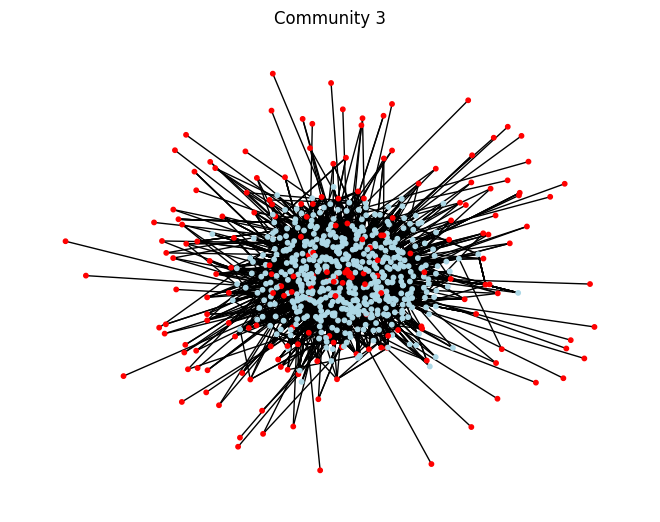

Community 4:
 Central Features (In-Degree Centrality):
  Node: 6445, In-Degree Centrality: 20.029689608636975
  Node: 460, In-Degree Centrality: 6.9527665317139
  Node: 9656, In-Degree Centrality: 4.47638326585695
  Node: 2416, In-Degree Centrality: 3.4439946018893384
  Node: 4554, In-Degree Centrality: 2.54251012145749
 Central Motifs (Out-Degree Centrality):
  Node: GAGGAG, Out-Degree Centrality: 0.8178137651821862
  Node: GGAGGA, Out-Degree Centrality: 0.786774628879892
  Node: GGGAGG, Out-Degree Centrality: 0.7192982456140351
  Node: AGGAGG, Out-Degree Centrality: 0.6572199730094467
  Node: GGAGGG, Out-Degree Centrality: 0.5708502024291497


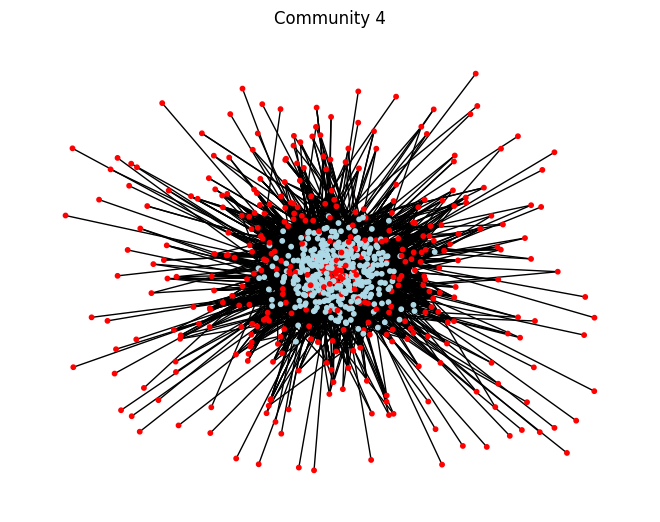

Community 5:
 Central Features (In-Degree Centrality):
  Node: 4014, In-Degree Centrality: 20.942928039702235
  Node: 1080, In-Degree Centrality: 3.042183622828784
  Node: 1802, In-Degree Centrality: 1.4168734491315136
  Node: 3776, In-Degree Centrality: 0.7320099255583127
  Node: 1261, In-Degree Centrality: 0.6972704714640199
 Central Motifs (Out-Degree Centrality):
  Node: CAGCCT, Out-Degree Centrality: 0.8511166253101737
  Node: GGCTGG, Out-Degree Centrality: 0.8337468982630273
  Node: TGGCCT, Out-Degree Centrality: 0.6178660049627791
  Node: GGCCAG, Out-Degree Centrality: 0.607940446650124
  Node: GCTGGG, Out-Degree Centrality: 0.5732009925558312


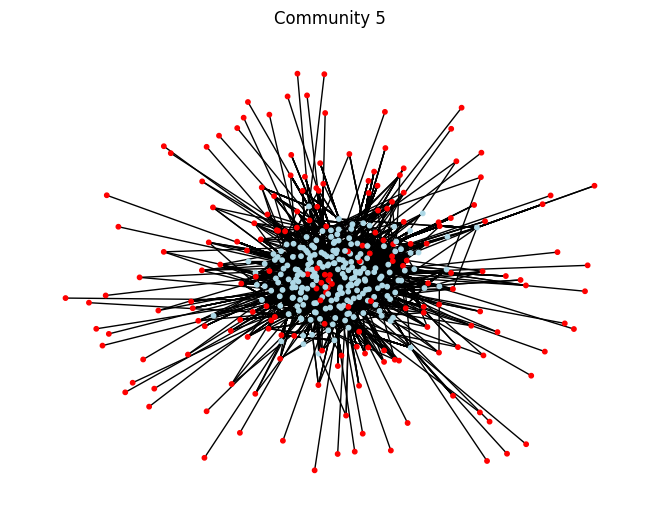

Community 6:
 Central Features (In-Degree Centrality):
  Node: 407, In-Degree Centrality: 104.25821596244131
  Node: 6296, In-Degree Centrality: 13.051643192488264
  Node: 835, In-Degree Centrality: 6.758215962441315
  Node: 7949, In-Degree Centrality: 5.516431924882629
  Node: 1235, In-Degree Centrality: 4.302816901408451
 Central Motifs (Out-Degree Centrality):
  Node: G, Out-Degree Centrality: 35.47417840375587
  Node: C, Out-Degree Centrality: 35.06572769953052
  Node: T, Out-Degree Centrality: 34.45774647887324
  Node: A, Out-Degree Centrality: 30.901408450704228
  Node: CCGCCG, Out-Degree Centrality: 0.8122065727699531


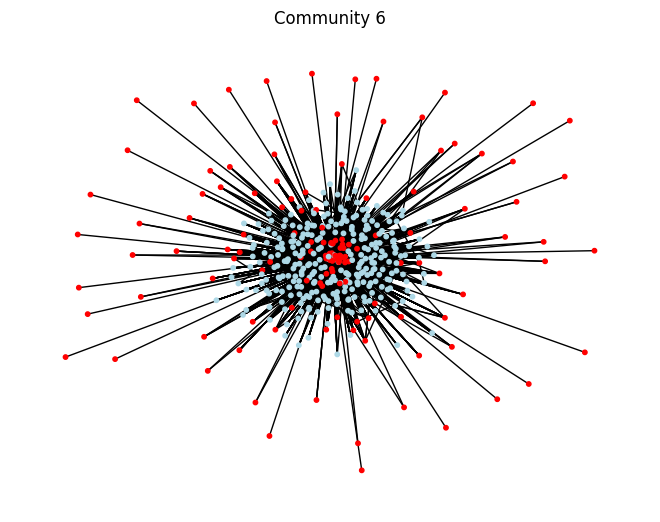

Community 7:
 Central Features (In-Degree Centrality):
  Node: 2558, In-Degree Centrality: 23.828205128205127
  Node: 1371, In-Degree Centrality: 2.158974358974359
  Node: 8596, In-Degree Centrality: 0.9512820512820512
  Node: 3550, In-Degree Centrality: 0.8948717948717949
  Node: 9128, In-Degree Centrality: 0.6923076923076923
 Central Motifs (Out-Degree Centrality):
  Node: GGCGGC, Out-Degree Centrality: 0.5641025641025641
  Node: GCGGCG, Out-Degree Centrality: 0.5538461538461539
  Node: GCCGGG, Out-Degree Centrality: 0.4358974358974359
  Node: GCTGCA, Out-Degree Centrality: 0.39487179487179486
  Node: CCGCGC, Out-Degree Centrality: 0.37948717948717947


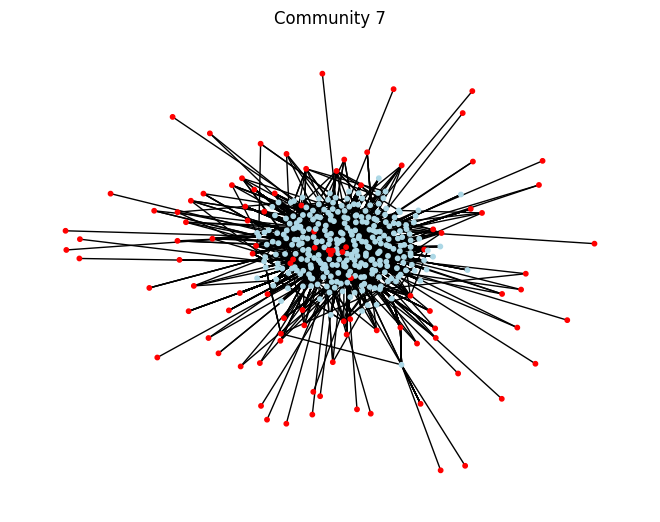

Community 8:
 Central Features (In-Degree Centrality):
  Node: 9685, In-Degree Centrality: 4.955307262569833
  Node: 8220, In-Degree Centrality: 3.368715083798883
  Node: 1317, In-Degree Centrality: 2.5921787709497206
  Node: 9853, In-Degree Centrality: 0.8659217877094972
  Node: 8413, In-Degree Centrality: 0.664804469273743
 Central Motifs (Out-Degree Centrality):
  Node: CCACTC, Out-Degree Centrality: 0.6089385474860335
  Node: CCACAC, Out-Degree Centrality: 0.5363128491620112
  Node: CACCAC, Out-Degree Centrality: 0.5363128491620112
  Node: ACCCCC, Out-Degree Centrality: 0.5027932960893855
  Node: CACCCC, Out-Degree Centrality: 0.4692737430167598


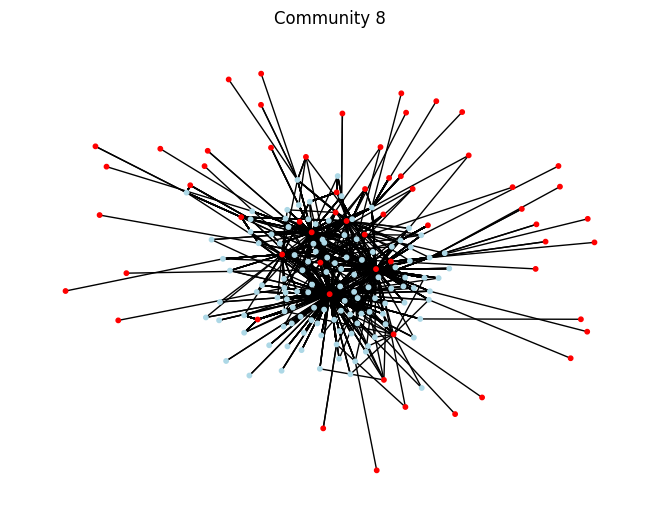

Community 9:
 Central Features (In-Degree Centrality):
  Node: 4793, In-Degree Centrality: 23.323955669224212
  Node: 1895, In-Degree Centrality: 2.4322250639386187
  Node: 2471, In-Degree Centrality: 0.9803921568627451
  Node: 2985, In-Degree Centrality: 0.4578005115089514
  Node: 6165, In-Degree Centrality: 0.32225063938618925
 Central Motifs (Out-Degree Centrality):
  Node: CTGTGG, Out-Degree Centrality: 0.16709292412617222
  Node: GAGTGC, Out-Degree Centrality: 0.13810741687979539
  Node: CAGTGG, Out-Degree Centrality: 0.13554987212276215
  Node: ATGGTG, Out-Degree Centrality: 0.1278772378516624
  Node: GTGCTG, Out-Degree Centrality: 0.12020460358056266


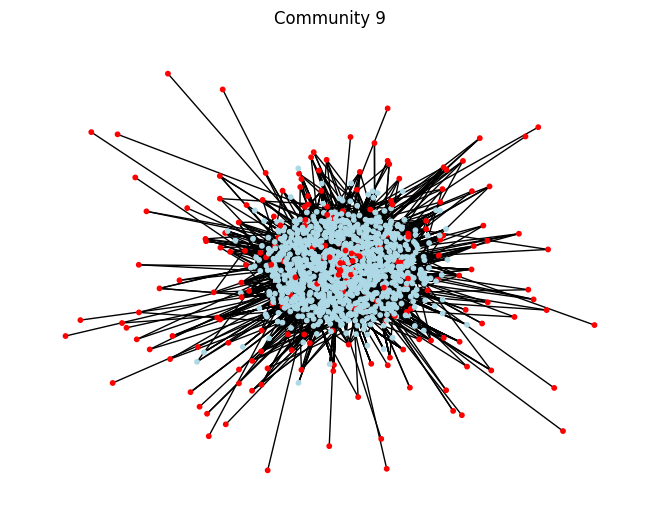

Community 10:
 Central Features (In-Degree Centrality):
  Node: 1399, In-Degree Centrality: 10.0
  Node: TACTCG, In-Degree Centrality: 0.0
 Central Motifs (Out-Degree Centrality):
  Node: TACTCG, Out-Degree Centrality: 10.0
  Node: 1399, Out-Degree Centrality: 0.0


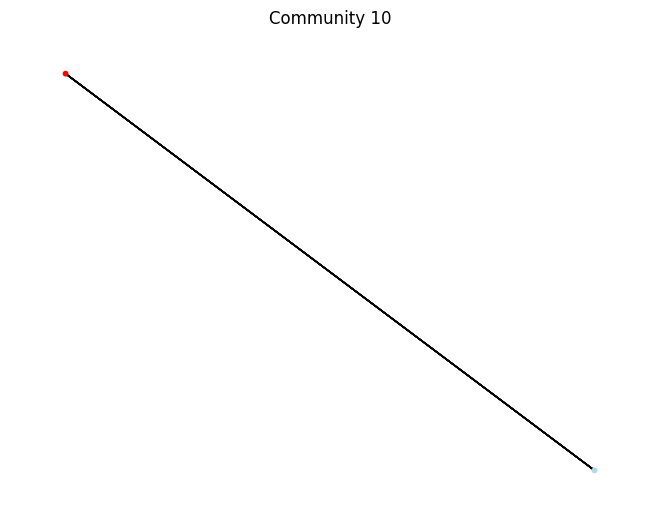

Community 11:
 Central Features (In-Degree Centrality):
  Node: 5458, In-Degree Centrality: 213.0
  Node: TGTGTG, In-Degree Centrality: 0.0
  Node: GTGTGT, In-Degree Centrality: 0.0
 Central Motifs (Out-Degree Centrality):
  Node: TGTGTG, Out-Degree Centrality: 127.5
  Node: GTGTGT, Out-Degree Centrality: 85.5
  Node: 5458, Out-Degree Centrality: 0.0


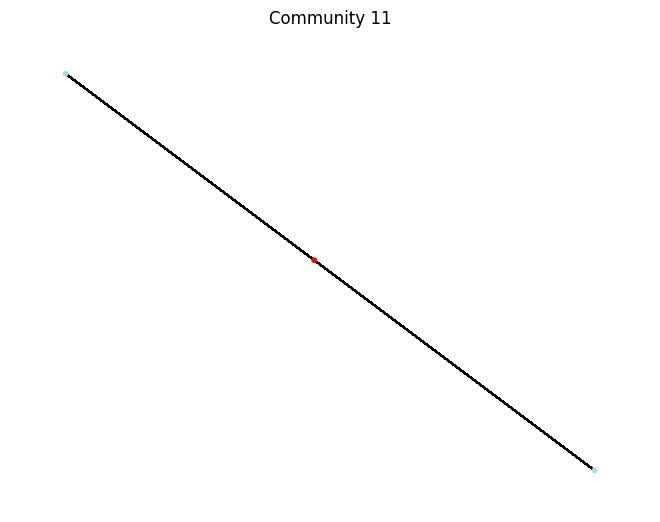

Community 12:
 Central Features (In-Degree Centrality):
  Node: 8707, In-Degree Centrality: 15.067857142857143
  Node: 4137, In-Degree Centrality: 6.164285714285714
  Node: 7834, In-Degree Centrality: 0.4607142857142857
  Node: 771, In-Degree Centrality: 0.40714285714285714
  Node: 9686, In-Degree Centrality: 0.3607142857142857
 Central Motifs (Out-Degree Centrality):
  Node: GCAGTG, Out-Degree Centrality: 0.6
  Node: GGTGTG, Out-Degree Centrality: 0.5107142857142857
  Node: CCTGGG, Out-Degree Centrality: 0.5107142857142857
  Node: TGTGGG, Out-Degree Centrality: 0.4928571428571428
  Node: GCCATG, Out-Degree Centrality: 0.48214285714285715


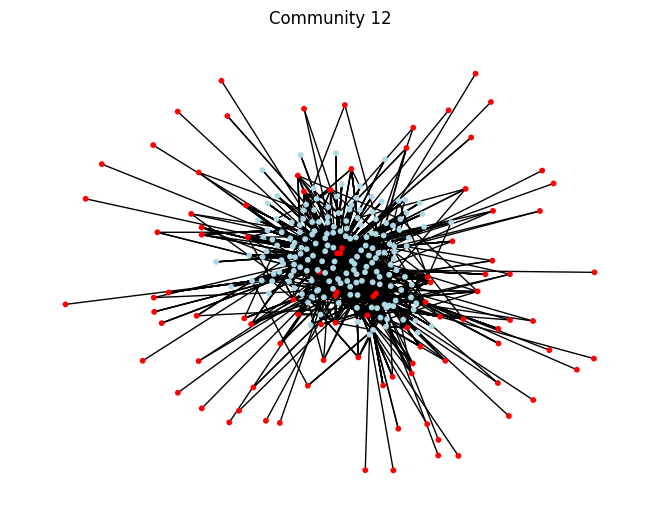

Community 13:
 Central Features (In-Degree Centrality):
  Node: 5234, In-Degree Centrality: 39.937254901960785
  Node: 2185, In-Degree Centrality: 8.933333333333334
  Node: 2763, In-Degree Centrality: 2.796078431372549
  Node: 9203, In-Degree Centrality: 1.380392156862745
  Node: 8372, In-Degree Centrality: 1.223529411764706
 Central Motifs (Out-Degree Centrality):
  Node: CCAGCC, Out-Degree Centrality: 1.9019607843137254
  Node: CCCAGC, Out-Degree Centrality: 1.8
  Node: CAGCCC, Out-Degree Centrality: 1.776470588235294
  Node: GCAGCC, Out-Degree Centrality: 1.5450980392156863
  Node: GCCACC, Out-Degree Centrality: 1.3254901960784313


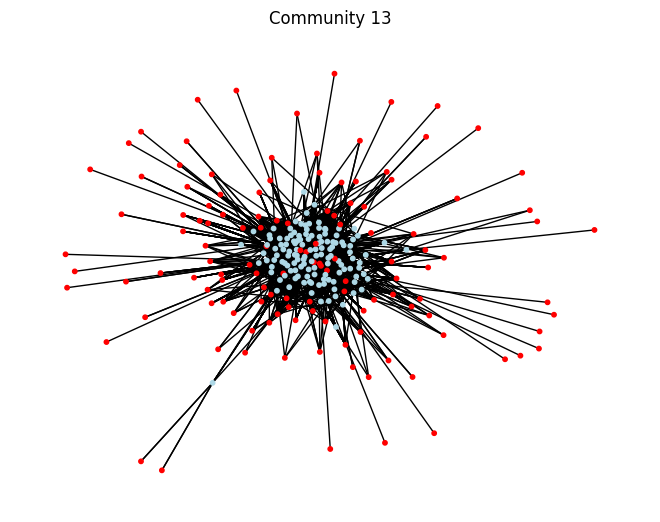

Community 14:
 Central Features (In-Degree Centrality):
  Node: 2953, In-Degree Centrality: 10.761904761904761
  Node: 238, In-Degree Centrality: 2.079365079365079
  Node: 7823, In-Degree Centrality: 1.0793650793650793
  Node: 396, In-Degree Centrality: 0.6825396825396826
  Node: 1977, In-Degree Centrality: 0.6825396825396826
 Central Motifs (Out-Degree Centrality):
  Node: CACTGC, Out-Degree Centrality: 1.9682539682539681
  Node: GCTGCT, Out-Degree Centrality: 1.1428571428571428
  Node: TCAAGC, Out-Degree Centrality: 0.9206349206349206
  Node: GCGCCG, Out-Degree Centrality: 0.8095238095238095
  Node: ATGCTG, Out-Degree Centrality: 0.7619047619047619


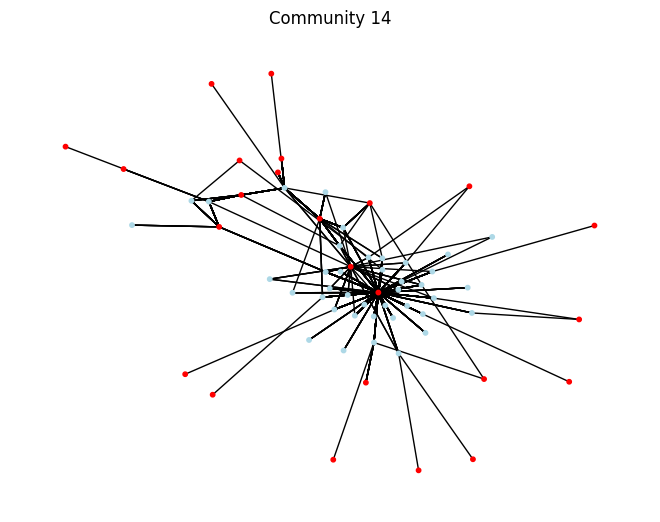

Community 15:
 Central Features (In-Degree Centrality):
  Node: 4831, In-Degree Centrality: 4.238095238095238
  Node: 7030, In-Degree Centrality: 4.161904761904762
  Node: 2996, In-Degree Centrality: 3.580952380952381
  Node: 9148, In-Degree Centrality: 2.980952380952381
  Node: 1781, In-Degree Centrality: 1.5714285714285714
 Central Motifs (Out-Degree Centrality):
  Node: TTTTTT, Out-Degree Centrality: 2.311111111111111
  Node: AAAAAA, Out-Degree Centrality: 1.2698412698412698
  Node: AGAAAA, Out-Degree Centrality: 0.9079365079365079
  Node: TTTCTT, Out-Degree Centrality: 0.6666666666666666
  Node: ATTTTT, Out-Degree Centrality: 0.638095238095238


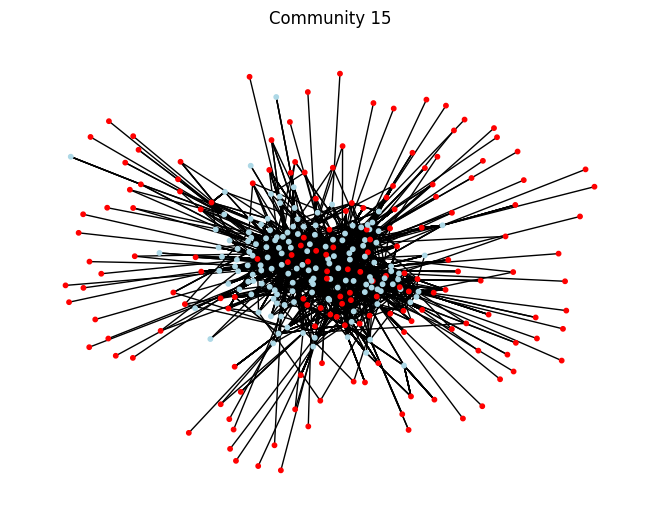

Community 16:
 Central Features (In-Degree Centrality):
  Node: 4458, In-Degree Centrality: 33.4
  Node: 5692, In-Degree Centrality: 0.4
  Node: TCTGAA, In-Degree Centrality: 0.0
  Node: ACTGGA, In-Degree Centrality: 0.0
  Node: CCTGGA, In-Degree Centrality: 0.0
 Central Motifs (Out-Degree Centrality):
  Node: TCTGGA, Out-Degree Centrality: 15.8
  Node: CCTGGA, Out-Degree Centrality: 10.0
  Node: ACTGGA, Out-Degree Centrality: 6.2
  Node: TCTGAA, Out-Degree Centrality: 1.8
  Node: 4458, Out-Degree Centrality: 0.0


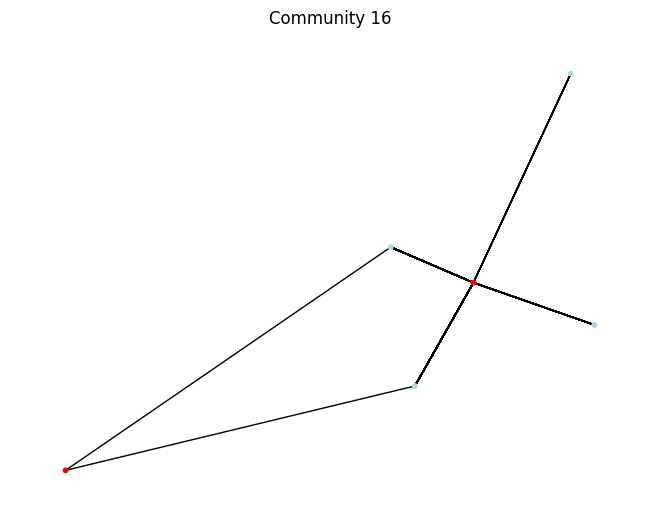

Community 17:
 Central Features (In-Degree Centrality):
  Node: 1017, In-Degree Centrality: 5.928571428571428
  Node: 9291, In-Degree Centrality: 5.285714285714286
  Node: 3898, In-Degree Centrality: 1.4285714285714284
  Node: 171, In-Degree Centrality: 0.7142857142857142
  Node: 9197, In-Degree Centrality: 0.3571428571428571
 Central Motifs (Out-Degree Centrality):
  Node: TTACAG, Out-Degree Centrality: 6.2142857142857135
  Node: AAAGTG, Out-Degree Centrality: 4.928571428571428
  Node: GAGTAG, Out-Degree Centrality: 3.2857142857142856
  Node: 6085, Out-Degree Centrality: 0.0
  Node: 459, Out-Degree Centrality: 0.0


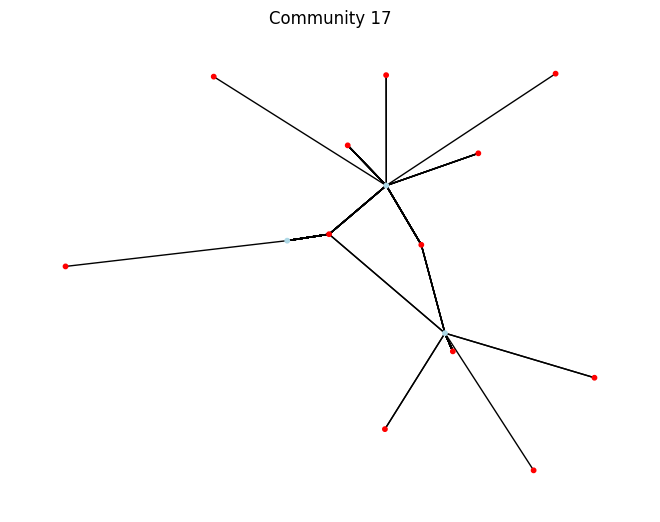

In [12]:
for i, c in enumerate(communities):
    graph = OG.subgraph(c)
    central_features = sorted(nx.in_degree_centrality(graph).items(), key=lambda x: x[1], reverse=True)[:5]
    central_motifs = sorted(nx.out_degree_centrality(graph).items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"Community {i}:")
    print(" Central Features (In-Degree Centrality):")
    for node, cent in central_features:
        print(f"  Node: {node}, In-Degree Centrality: {cent}")
    print(" Central Motifs (Out-Degree Centrality):")
    for node, cent in central_motifs:
        print(f"  Node: {node}, Out-Degree Centrality: {cent}")
    graph = graph.to_undirected()
    nx.draw(graph, pos=nx.spring_layout(graph), with_labels=False, node_size=10, font_size=4, node_color=[node_color(n) for n in graph.nodes()])
    plt.title(f"Community {i}")
    plt.show()